In [13]:
from openpyxl import load_workbook # xlsx sheet reader
import pandas as pd # dataframe library
import numpy as np # linear algebra
from tqdm import tqdm # loading bar / cosmetic
import chart_studio.plotly as py
from plotly.graph_objs import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from subprocess import check_output
print(check_output(["ls", "assets/data"]).decode("utf8"))


mort.XLSX
mort.csv
mortality.db



In [2]:
def function_value_split (array):
        
    array = str(array)
       
    avg = float(array.split('(')[0])

    y = array.split('(')[1]

    min_value = float(y.split(',')[0])

    max_value = float(y.split(',')[1].replace(')',''))   
    
    return (avg, min_value, max_value)

In [3]:
sheet_names = [u'HIV-AIDS & tuberculosis',
 u'Diarrhea, lower respiratory',
 u'Neglected tropical diseases',
 u'Maternal disorders',
 u'Neonatal disorders',
 u'Nutritional deficiencies',
 u'Other communicable, maternal, ',
 u'Neoplasms',
 u'Cardiovascular diseases',
 u'Chronic respiratory diseases',
 u'Cirrhosis & other chronic ',
 u'Digestive diseases',
 u'Neurological disorders',
 u'Mental & substance use ',
 u'Diabetes, urogenital, blood',
 u'Musculoskeletal disorders',
 u'Other non-communicable ',
 u'Transport injuries',
 u'Unintentional injuries',
 u'Self-harm & interpersonal ',
 u'Forces of nature, war, & legal ']

df = {}

for sheet in tqdm(sheet_names):
    
    df[sheet.strip()]  = pd.read_excel('assets/data/mort.xlsx', skiprows=1)

100%|██████████| 21/21 [02:55<00:00,  8.34s/it]


In [4]:
sheets = [x.strip() for x in sheet_names]

main_df = pd.DataFrame([], columns=['condition','1980','1985','1990','1995','2000','2005','2010','2014','% change 1980-2014'])

for sheet in sheets:
    
    dummy_array = []
    
    dummy_array = dummy_array + [sheet]
    
    columns = df[sheet].columns[2:]
    
    for column in columns:
    
        (avg, min_v, max_v) = function_value_split (df[sheet].loc[0, column])
        
        dummy_array = dummy_array + [avg]
        
    main_df.loc[len(main_df)] = dummy_array
    
main_df.loc[len(main_df)] = main_df.sum(0)
main_df.loc[len(main_df)-1, 'condition'] = 'sum'

A = main_df.loc[main_df['condition']=='sum', main_df.columns[1:-1]]
B = main_df.loc[main_df['condition']=='sum', main_df.columns[1:-1]].T.shift(1).T

perc_decrease = np.round (1-A/B,3)

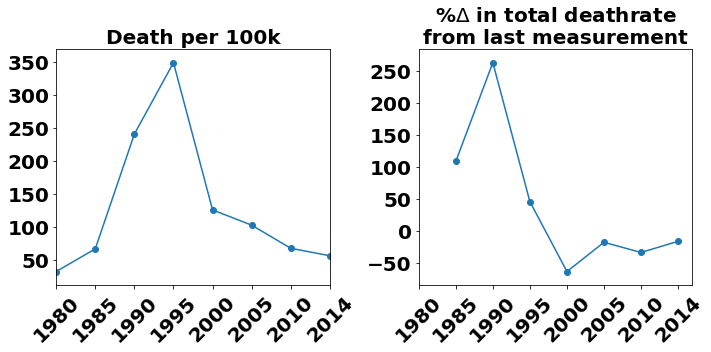

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

text_opts = {'fontsize':20, 'fontweight':'bold'}

y = main_df[main_df.columns[1:-1]].loc[len(main_df)-1]
x = np.arange (len(main_df.columns[1:-1]))

y.plot()
plt.scatter(x,y)

plt.title ('Death per 100k', **text_opts)
plt.xticks(rotation='45', **text_opts)
plt.yticks(**text_opts);

plt.subplot(1,2,2)

y = -perc_decrease.loc[21].values*100
x = np.arange (len(main_df.columns[1:-1]))

plt.plot(x,y)
plt.scatter(x,y)

plt.title ('%$\Delta$ in total deathrate\nfrom last measurement', **text_opts)
plt.xticks(x, main_df.columns[1:-1], rotation='45', **text_opts)
plt.yticks(**text_opts);

plt.tight_layout()

In [14]:
fig = plt.gcf()
plotly_fig = tls.mpl_to_plotly(fig)
py.iplot(plotly_fig)

NameError: name 'tls' is not defined

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Deathrate Ratio per Condition (2014)')

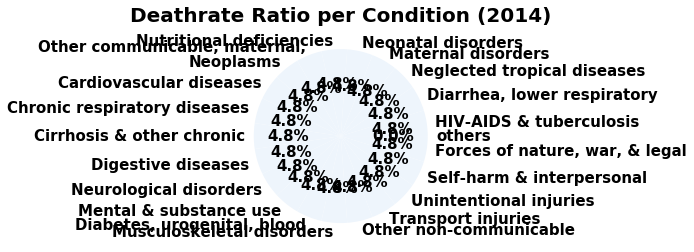

In [9]:
threshold = 0.03

indexes = []

values = []

others = 0

for index in main_df['condition'][:-1]:
    
    temp_value = main_df.loc[main_df['condition']==index, '2014']
    
    temp_perc = temp_value / float (main_df.loc[main_df['condition']=='sum', '2014'])
    
    if temp_perc.get_values()[0] >= threshold:
        
        indexes = indexes + [index] 
        
        values = values + [temp_perc.get_values()[0]]
        
    else:
        
        others = others + temp_perc.get_values()[0]

indexes = indexes + ['others']

values = values + [others]

cmap = cm.Blues

mpl.rcParams['font.size'] = 15.0
mpl.rcParams['font.weight'] = 'bold'

plt.pie(values, labels=indexes, autopct='%1.1f%%', colors = cmap(values));

plt.title('Deathrate Ratio per Condition (2014)', **text_opts)

In [10]:
condition_progression = {}

for index in main_df.index[:-1]:
    
    condition = main_df.loc[index, 'condition']
    
    condition_progression[condition]=[]
    
    for column in main_df[main_df.columns[1:-1]]:
        
        condition_progression[condition] = condition_progression[condition] + [main_df.loc[index,column]/float(main_df.loc[len(main_df)-1,column])]

/Users/elimenas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



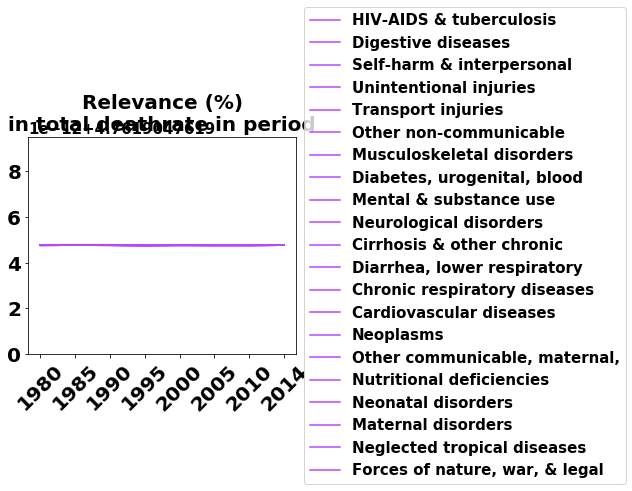

In [11]:
min_v = np.min(min(condition_progression.values()))
max_v = np.max(max(condition_progression.values()))

norm = mpl.colors.Normalize(vmin=min_v, vmax=max_v)
cmap = cm.cool

cmap_normalized = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
ax = plt.subplot(111)

lgd_array = pd.DataFrame([], columns = ['label','mean'])

for condition in condition_progression:
    
    lgd_array.loc[len(lgd_array)]  = [condition,np.mean(condition_progression[condition])]

lgd_array = lgd_array.sort_values('mean', ascending=False)

for condition in lgd_array['label']:
    
    color = cmap_normalized.to_rgba(np.mean(condition_progression[condition]))
    
    plt.plot(np.arange(len(condition_progression[condition])), np.multiply(condition_progression[condition],100), c=color)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(lgd_array.label, loc='center left', bbox_to_anchor=(1, 0.5))

x = np.arange (len(main_df.columns[1:-1]))

plt.title ('Relevance (%)\nin total deathrate in period', **text_opts)
plt.xticks(x, main_df.columns[1:-1], rotation='45', **text_opts)
plt.yticks(**text_opts);

plt.tight_layout()